## Importing Necessary Libraries
Import statements for the necessary libraries:
- Standard libraries like `json` for handling JSON files.
- Third-party libraries such as `numpy`, `matplotlib`, `seaborn`, `tensorflow`, and `sklearn` for data manipulation, visualization, machine learning, and deep learning tasks.



In [34]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

## Specifying the Dataset Path
This line sets the path to the dataset:
- `json_data_path` (str): The file path to the JSON file containing the dataset.


In [35]:
music_data_json_path = "git.json"

## Configuring TensorFlow for GPU Usage
Two functions are defined here to configure and test TensorFlow's GPU usage:

1. `configure_gpu`: This function checks for the availability of a GPU and configures TensorFlow to use it if available. It returns `True` if a GPU is configured, otherwise `False`. Exception handling is included to catch and print any errors during configuration.

2. `gpu_test_computation`: This function performs a simple test computation on the GPU, if available. It multiplies two tensors and prints the result to demonstrate that the GPU is being used.

After defining these functions, TensorFlow's version is printed, and `configure_gpu` is called to configure the GPU. If successful, `gpu_test_computation` is executed to demonstrate GPU computation.

In [36]:
def configure_gpu():
    try:
        gpu_devices = tf.config.experimental.list_physical_devices('GPU')
        if not gpu_devices:
            print("No GPU devices found. TensorFlow will use CPU.")
            return False
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        return True
    except Exception as e:
        print(f"Error configuring TensorFlow to use GPU: {e}")
        return False


def gpu_test_computation():
    with tf.device('/GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
        b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
        c = a * b
        print("Result of GPU computation:", c.numpy())


print(f"TensorFlow Version: {tf.__version__}")
if configure_gpu():
    gpu_test_computation()


TensorFlow Version: 2.10.1
Result of GPU computation: [5. 8. 9. 8. 5.]


## Loading Data from JSON
The function `load_data` is designed to load the dataset from a JSON file. It takes a single argument:
- `data_path` (str): The file path to the JSON dataset.

The function returns a tuple containing two elements:
- `X`: A NumPy array of extracted features (mfccs).
- `Y`: A NumPy array of corresponding labels.


In [37]:
def load_music_data(data_path):
    with open(data_path, "r") as file:
        data = json.load(file)

    features = np.array(data["mfcc"])
    labels = np.array(data["labels"])
    print('Data successfully loaded')
    return features, labels


try:
    features, labels = load_music_data(music_data_json_path)
except Exception as e:
    print(f"Error loading data: {e}")

Data successfully loaded


## Splitting Data into Training, Validation, and Test Sets
The `split_data` function divides the dataset into training, validation, and test sets.

Args:
- `test_size` (float): Proportion of the dataset to include in the test split.
- `validation_size` (float): Proportion of the training set to include in the validation split.

Returns:
- Tuple containing six datasets: `X_train`, `X_validation`, `X_test`, `y_train`, `y_validation`, and `y_test`.



In [38]:
def split_dataset(test_size, validation_size):
    features, labels = load_music_data(music_data_json_path)

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=test_size)
    features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, test_size=validation_size)

    features_train = features_train[..., np.newaxis]
    features_validation = features_validation[..., np.newaxis]
    features_test = features_test[..., np.newaxis]

    return features_train, features_validation, features_test, labels_train, labels_validation, labels_test

## Function for Plotting Training History
The `plot_history` function is designed for visualizing the training history of a machine learning model. Its parameters are as follows:

- `history` (History object): The training history returned by the `fit` method of a Keras model. Contains metrics recorded during training.
- `metrics` (list of str): Specifies the list of metrics to plot. Default is `['loss', 'accuracy']`. This allows for flexibility in choosing which metrics to visualize.
- `figsize` (tuple): Determines the size of the figure. This parameter allows customization of the plot's dimensions.
- `save_path` (str): The file path for saving the plot image. This provides flexibility in specifying where to save the generated plot.

The function generates a plot for each specified metric, comparing training and validation results. It saves the plot as an image at the specified `save_path` and displays it inline.



In [53]:
def plot_training_history(history, save_path, metrics=None, figsize=(16, 10)):
    if metrics is None:
        metrics = ['loss', 'accuracy']

    sn.set(style="whitegrid")
    plt.figure(figsize=figsize)

    color_palette = ['#E28F83', '#83C5BE', '#F9D276', '#76B7F9']

    for i, metric in enumerate(metrics):
        if metric not in history.history:
            print(f"Warning: '{metric}' not found in history.")
            continue

        plt.subplot(2, 1, i + 1)
        plt.subplots_adjust(hspace=0.5)

        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}', color=color_palette[2 * i], linewidth=2)
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}', color=color_palette[2 * i + 1], linewidth=2)

        plt.legend(frameon=True)
        plt.title(f'Training and Validation {metric.capitalize()}', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved successfully as '{save_path}'")

In [59]:
def plot_confusion_matrix(cm, genre_labels, save_path):
    plt.figure(figsize=(10, 7))
    sn.set(font_scale=1.1)
    ax = sn.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=.5)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    ax.set_xticklabels(genre_labels, rotation=45, ha='right')
    ax.set_yticklabels(genre_labels, rotation=0)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved successfully as '{save_path}'")

## Constructing a Convolutional Neural Network

The `build_model` function defines a convolutional neural network (CNN) for classification tasks. Key aspects of the function include:

- `input_shape` (tuple): The shape of the input data fed into the CNN.
- `num_classes` (int): The number of output classes for the classification.

The CNN architecture includes:
- Three convolutional layers, each followed by max-pooling, batch normalization, and dropout layers.
- After flattening the output from the convolutional layers, the network includes a dense layer with L2 regularization, followed by a dropout layer.
- The final layer is a dense layer with a softmax activation function, suitable for multi-class classification.

In [45]:
def build_genre_classification_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

## Making Predictions with the Model
The `predict_genre` function is designed to make predictions using a trained machine learning model:
- `model`: The pre-trained model to use for making predictions.
- `features`: The input data for which predictions are to be made. It is expected to be in a format compatible with the model's input shape.
- `label`: The true label associated with the input data.

In [46]:
genres = ['BLUES', 'CLASSICAL', 'COUNTRY', 'DISCO', 'HIPHOP', 'JAZZ', 'METAL', 'POP', 'REGGAE', 'ROCK']


def predict_genre(model, features, label):
    features = features[np.newaxis, ...]

    prediction = model.predict(features)
    predicted_genre_index = np.argmax(prediction, axis=1)

    actual_genre = genres[label.item()]
    predicted_genre = genres[predicted_genre_index.item()]

    print(f"Actual Genre: {actual_genre}, Predicted Genre: {predicted_genre}")

## Data Splitting and Model Setup
This code snippet performs data splitting and sets up a machine learning model for training. It calls the following functions:

- `split_data(test_size, validation_size)`:
  - Args:
    - `test_size` (float): Proportion of the dataset to include in the test split.
    - `validation_size` (float): Proportion of the training set to include in the validation split.
  - Returns:
    - A tuple containing six datasets: `X_train`, `X_validation`, `X_test`, `y_train`, `y_validation`, `y_test`.

- `build_model(input_shape)`:
  - Args:
    - `input_shape` (tuple): Shape of the input data for the model.
  - Returns:
    - The constructed machine learning model.

- Model Compilation (`model.compile`):
  - Args:
    - `optimizer` (Adam with a learning rate of 0.0001): Specifies the optimization algorithm.
    - `loss` ('sparse_categorical_crossentropy'): Defines the loss function for training.
    - `metrics` (['accuracy']): Specifies evaluation metrics.


In [47]:
features_train, features_validation, features_test, labels_train, labels_validation, labels_test = split_dataset(0.2, 0.2)

Data successfully loaded


In [48]:
input_shape = (features_train.shape[1], features_train.shape[2], 1)
genre_classification_model = build_genre_classification_model(input_shape)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
genre_classification_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [49]:
genre_classification_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 64)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 6, 64)        256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 64, 6, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 128)        73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 2, 128)      

## Training the Genre Classification Model
Here, the model is trained on the dataset:
- `training_history`: Stores the history of model training for later analysis. It includes loss and accuracy metrics for each epoch.
- The `fit` method is used to train the model with specified batch size and number of epochs.


In [50]:
training_history = genre_classification_model.fit(features_train, labels_train, validation_data=(features_validation, labels_validation), batch_size=32, epochs=150)

Epoch 1/150
200/200 [==============================] - 3s 9ms/step - loss: 2.7000 - accuracy: 0.2283 - val_loss: 1.9661 - val_accuracy: 0.4244
Epoch 2/150
200/200 [==============================] - 1s 6ms/step - loss: 2.2328 - accuracy: 0.3238 - val_loss: 1.8692 - val_accuracy: 0.4225
Epoch 3/150
200/200 [==============================] - 1s 7ms/step - loss: 2.0238 - accuracy: 0.3810 - val_loss: 1.7910 - val_accuracy: 0.4288
Epoch 4/150
200/200 [==============================] - 1s 7ms/step - loss: 1.9183 - accuracy: 0.4192 - val_loss: 1.6850 - val_accuracy: 0.4550
Epoch 5/150
200/200 [==============================] - 1s 7ms/step - loss: 1.8179 - accuracy: 0.4423 - val_loss: 1.7068 - val_accuracy: 0.4450
Epoch 6/150
200/200 [==============================] - 1s 7ms/step - loss: 1.7584 - accuracy: 0.4579 - val_loss: 1.6910 - val_accuracy: 0.4387
Epoch 7/150
200/200 [==============================] - 1s 7ms/step - loss: 1.6931 - accuracy: 0.4912 - val_loss: 1.6992 - val_accuracy: 0.4588

## Saving the Trained Model
The trained model is saved to the disk for future use:
- `genre_classification_model.save`: Saves the model in HDF5 format.
- A try-except block is used to catch and report any errors during the save process.


In [52]:
try:
    genre_classification_model.save('genre_classification_model.h5')
    print("Model saved successfully as 'genre_classification_model.h5'")
except Exception as e:

    print(f"Error occurred while saving the model: {e}")

Model saved successfully as 'genre_classification_model.h5'


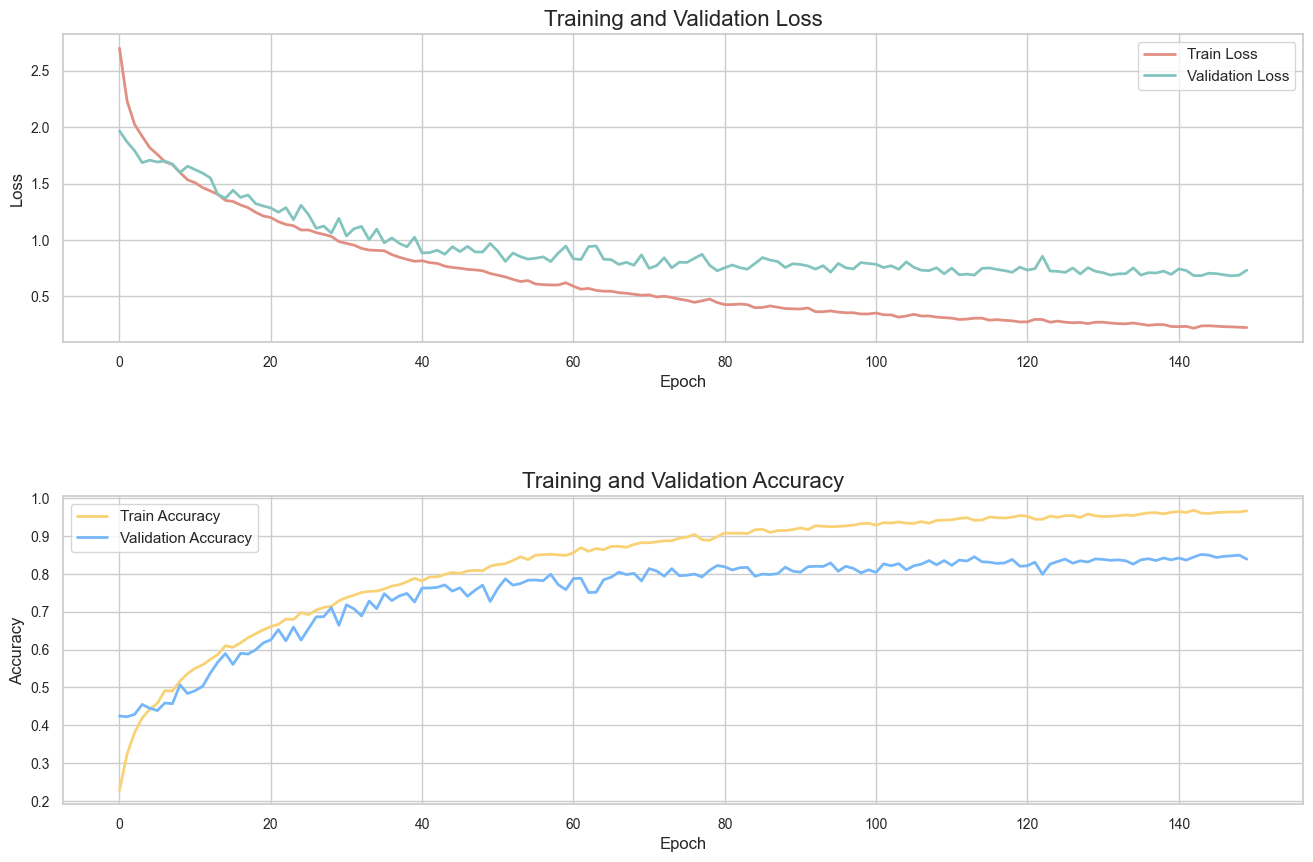

Plot saved successfully as 'plots/training_history.png'


In [54]:
plot_training_history(training_history, save_path='plots/training_history.png')

## Evaluating the Model on Test Data
Evaluating the model's performance on unseen test data:
- `model.evaluate`: Computes the loss and accuracy of the model on the test dataset.
- Test accuracy is printed to assess model performance.


In [55]:
test_loss, test_accuracy = genre_classification_model.evaluate(features_test, labels_test, verbose=1)
print('\nTest accuracy:', test_accuracy)

63/63 [==============================] - 1s 7ms/step - loss: 0.7469 - accuracy: 0.8375

Test accuracy: 0.8374999761581421


## Predicting Music Genres and Analyzing Performance
Predicting music genres using the trained model and analyzing its performance:
- `predict_genre`: A function to predict the genre of a given audio feature set.
- `accuracy_score`: Calculates the accuracy of the predictions against the actual labels.
- A confusion matrix is generated to visualize the model's performance across different genres.


In [56]:
predicted_genres = genre_classification_model.predict(features_test)
predicted_labels = [np.argmax(i) for i in predicted_genres]

print("Accuracy on Test Data:", accuracy_score(labels_test, predicted_labels))

63/63 [==============================] - 0s 5ms/step
Accuracy on Test Data: 0.8375


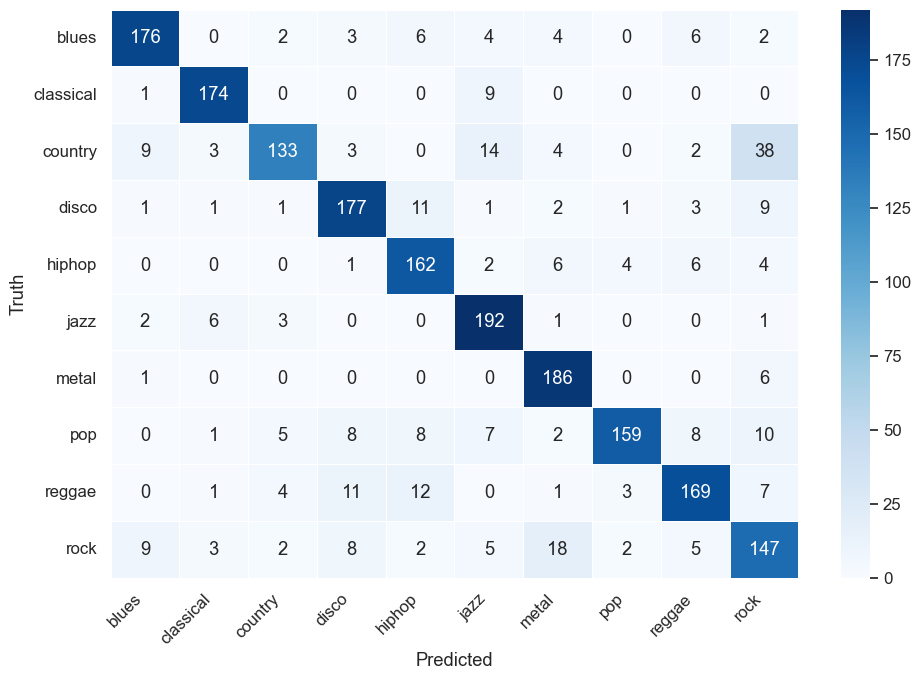

Plot saved successfully as 'plots/confusion_matrix.png'


In [60]:
confusion_matrix = tf.math.confusion_matrix(labels=labels_test, predictions=predicted_labels)
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
plot_confusion_matrix(confusion_matrix, genre_labels, save_path='plots/confusion_matrix.png')

## Making a Sample Prediction
Performing a sample prediction to demonstrate the model's usage:
- A single sample from the test dataset is selected.
- The `predict_genre` function is used to predict the genre of this sample.


In [61]:
sample_features = features_test[100]
sample_label = labels_test[100]
predict_genre(genre_classification_model, sample_features, sample_label)

1/1 [==============================] - 0s 16ms/step
Actual Genre: POP, Predicted Genre: POP
